In [1]:
import copy
from scipy.stats import ttest_ind

import pylab
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Model
import keras.models
import keras.layers as layers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from keras import backend as K

import argparse
import cnn_analyzer as cnna
import cnn_builder as cbuild
import cnn_runner as crun
import config
import csv
import niftiutils.helper_fxns as hf
import niftiutils.private as prv
import importlib
import inference_methods_squash as im
import itertools
from math import sqrt, log, pi, exp, e
import matplotlib.pyplot as plt
from numba import jit, njit, prange, vectorize, guvectorize
from numpy import matmul, diag
import numpy as np
import operator
import os
import pandas as pd
import random
import scipy
import time
import dr_methods as drm
%matplotlib inline

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
importlib.reload(config)
importlib.reload(hf)
importlib.reload(cbuild)
importlib.reload(crun)
C = config.Config()
T = config.Hyperparams()

In [3]:
def kl_div(m1, sig1, m2, sig2, one_sided="none"):
    #returns kl(p,q) where p~N(m1,s1), q~N(m2,s2)
    ret = np.log(sig2/sig1) + (sig1**2+(m1-m2)**2)/(2*sig2**2) - .5
    if one_sided=="less":
        return ret * (m1 < m2)
    elif one_sided=="greater":
        return ret * (m1 > m2)
    else:
        return ret

In [4]:
model = keras.models.load_model(os.path.join(C.model_dir, "models_305.hdf5")) #models_305

model_conv2 = cbuild.build_pretrain_model(model, last_layer=-5)
model_conv3 = cbuild.build_pretrain_model(model, last_layer=-4)
model_pre_act = cbuild.build_pretrain_model(model, last_layer=-3)
model_act = cbuild.build_pretrain_model(model, last_layer=-2)

In [6]:
orig_data_dict, num_samples = cbuild._collect_unaug_data()

features_by_cls, feat_count = cnna.collect_features()
feat_count.pop("central scar")
all_features = list(feat_count.keys())
cls_features = {f: [c for c in C.classes_to_include if f in features_by_cls[c]] for f in all_features}

Z_features = cnna.get_annotated_files(features_by_cls)
Z_features.pop("central scar")

['12572068_0', '13092836_1', 'E103354630_0', 'E105921537_0', 'E106010098_0']

In [114]:
D = np.empty((8,8,4))
for x in range(D.shape[0]):
    for y in range(D.shape[1]):
        for z in range(D.shape[2]):
            D[x,y,z] = (D.shape[0]-.5-x)**2 + (D.shape[1]-.5-y)**2 + 4*(D.shape[2]-.5-z)**2

voi_df = drm.get_voi_dfs()[0]
Z = np.concatenate([orig_data_dict[cls][1] for cls in C.classes_to_include], 0)

all_dense = np.empty([0,100])
all_conv3 = np.empty([0,128*4])

aug_factor = 10
for img_id in range(len(Z)):
    voi_row = voi_df.loc[Z[img_id]]
    for aug_id in range(aug_factor):
        img = np.load(os.path.join(C.aug_dir, voi_row['cls'], "%s_%d.npy" % (Z[img_id], aug_id)))
        
        activ = model_pre_act.predict(np.expand_dims(img, 0))
        all_dense = np.concatenate([all_dense, activ], axis=0)
        
        activ = model_conv3.predict(np.expand_dims(img, 0))
        all_conv3 = np.concatenate([all_conv3, get_shells(activ, D)], axis=0)

In [128]:
all_neurons = np.concatenate([all_conv3, all_dense], axis=1)

In [116]:
def get_shells(activ, D):
    shell4 = activ[0, D > 85, :].mean(axis=0)
    shell3 = activ[0, (D <= 85) & (D > 62), :].mean(axis=0)
    shell2 = activ[0, (D <= 62) & (D > 39), :].mean(axis=0)
    shell1 = activ[0, D <= 39, :].mean(axis=0)
    return np.expand_dims(np.concatenate([shell1, shell2, shell3, shell4]), 0)

In [115]:
num_neurons = all_dense.shape[1] + all_conv3.shape[1]

In [117]:
feature_dense = {f:np.empty([0,100]) for f in all_features}
feature_conv3 = {f:np.empty([0,128*4]) for f in all_features}

aug_factor = 80
for f in all_features:
    Z = Z_features[f]
    for img_id in range(len(Z)):
        voi_row = voi_df.loc[Z[img_id]]
        for aug_id in range(aug_factor):
            img = np.load(os.path.join(C.aug_dir, voi_row['cls'], "%s_%d.npy" % (Z[img_id], aug_id)))
            activ = model_pre_act.predict(np.expand_dims(img, 0))
            feature_dense[f] = np.concatenate([feature_dense[f], activ], axis=0)
        
            activ = model_conv3.predict(np.expand_dims(img, 0))
            feature_conv3[f] = np.concatenate([feature_conv3[f], get_shells(activ, D)], axis=0)

In [135]:
feature_neurons = {f:np.concatenate([feature_conv3[f], feature_dense[f]], axis=1) for f in all_features}

In [146]:
Z_test = ['E106097391_0', 'E104978772_1', '12900535_0', 'E100150242_0', 'E105490014_0', 'E103147618_0', 'E103510187_0', 'E104657225_0', 'E100551966_0', 'E101388602_0', 'E100215900_8', 'E100215900_7', 'E104045692_0', '13104521_0', 'E100383453_0', '12943286_0', '12271995_0', 'E102315724_0', 'E104949189_0', 'E100511083_1', 'E101579471_0', '13018986_1', '13203550_8', '13112385_0', '12712463_0', '12361082_0', '13028374_0', 'E103985934_1', 'E100529980_0', '12042703_3', '12961059_0', 'E105724706_2', 'E100592424_2', 'E103104254_0', 'E104546069_0', 'E101665217_1', '12090000_0', 'E100592424_1', '12961059_1', 'E105474285_0', '12502068_1', 'E100814791_0', 'E102613189_0', 'E105427046_0', 'E102881031_1', 'E102929168_0', 'E102310482_0', 'E102095465_0', 'E101811299_0', 'E104737273_0', '12890053_0', 'E100168661_1', '12637865_0', 'E100168661_2', '12239783_0', '12707781_0', '12706568_1', '12823036_0', '12404081_0', '12365693_1']

num_features = len(all_features) # number of features
num_units = 100 # number of dense units

num_annotations = 8

all_imgs = [orig_data_dict[cls][0] for cls in C.classes_to_include]
all_imgs = np.array(hf.flatten(all_imgs))

all_lesionids = [orig_data_dict[cls][1] for cls in C.classes_to_include]
all_lesionids = np.array(hf.flatten(all_lesionids))

test_indices = np.where(np.isin(all_lesionids, Z_test))[0]

fixed_indices = np.empty([num_features, num_annotations])
for f_ix,f in enumerate(all_features):
    fixed_indices[f_ix, :] = np.where(np.isin(all_lesionids, random.sample(set(Z_features[f]), num_annotations)))[0]
fixed_indices = fixed_indices.astype(int)

x_test = all_imgs[test_indices]
z_test = all_lesionids[test_indices]

In [170]:
x = np.linspace(-3,3, num=1000)

In [171]:
y = scipy.stats.norm.pdf(x, loc=m[0],scale=s[0])

In [195]:
F = feature_neurons[all_features[0]]
y2 = scipy.stats.norm.pdf(x, loc=F.mean(axis=0)[0],scale=F.std(axis=0)[0])

In [194]:
F.mean(axis=0)[0]

-0.5886752939191502

In [204]:
F = feature_neurons[all_features[2]]
y3 = scipy.stats.norm.pdf(x, loc=F.mean(axis=0)[0],scale=F.std(axis=0)[0])

In [209]:
F = feature_neurons[all_features[10]]
y4 = scipy.stats.norm.pdf(x, loc=F.mean(axis=0)[0],scale=F.std(axis=0)[0])

In [227]:
y_test = scipy.stats.norm.pdf(x, loc=m_test[0],scale=s_test[0])

In [241]:
test_neurons.std(axis=0)

c_ix = C.classes_to_include.index(cls)
w_u = np.empty((num_features, num_neurons))
p_fu = np.empty((num_features, num_neurons))

for f_ix in range(num_features):
    F = feature_neurons

(6360, 612)

In [352]:
all_cov = np.cov(all_neurons.T)
test_cov = np.cov(test_neurons.T)

In [411]:
p_f = np.empty(num_features)
for f_ix in range(num_features):
    f_neurons = feature_neurons[all_features[f_ix]]
    f_m = f_neurons.mean(0)
    f_cov = np.cov(f_neurons.T)

    samp = scipy.random.multivariate_normal(m_test, test_cov, size=1000)
    lnphf = scipy.stats.multivariate_normal.logpdf(samp, f_m, f_cov, allow_singular=True)
    lnph = scipy.stats.multivariate_normal.logpdf(samp, m, all_cov, allow_singular=True)
    
    adj = np.max(lnphf - lnph)
    p_f[f_ix] = np.log(np.mean(np.exp(lnphf - lnph - adj))) + adj
p_f -= np.min(p_f)

In [418]:
y_test = scipy.stats.norm.pdf(x, loc=m_test[0]+1,scale=s_test[0])

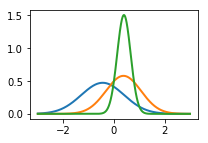

In [420]:
plt.figure(figsize=(3,2))
plt.plot(x,y,linewidth=2)
plt.plot(x,y2,linewidth=2)
plt.plot(x,y_test,linewidth=2)

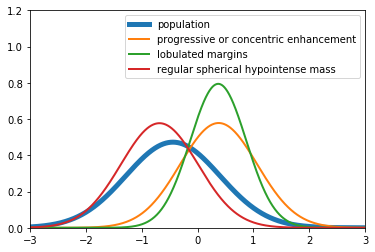

In [222]:
#plt.figure(figsize=(8,7))
plt.plot(x,y,linewidth=5, label='population')
plt.plot(x,y2,linewidth=2, label=all_features[0])
plt.plot(x,y3,linewidth=2, label=all_features[2])
plt.plot(x,y4,linewidth=2, label=all_features[10])
plt.axis([-3,3,0,1.2])
plt.legend()

In [136]:
# information provided by a feature about the possible values of a neuron, higher KL means that neuron should be weighted more
KL = np.zeros((num_features, num_neurons))
m = all_neurons.mean(axis=0)
s = all_neurons.std(axis=0)
for f_ix in range(num_features):
    F = feature_neurons[all_features[f_ix]]
    KL[f_ix, :] = kl_div(m,s, F.mean(axis=0),F.std(axis=0), one_sided="less")
    #KL[f_ix, :] = ttest_ind(F, all_pre_act, equal_var=False)

In [159]:
test_dense = np.empty([0,100])
test_conv3 = np.empty([0,128*4])

p_f = np.empty(num_features)
img_id = 1
voi_row = voi_df.loc[z_test[img_id]]
cls = voi_row['cls']
aug_factor = 100
for aug_id in range(aug_factor):
    img = np.load(os.path.join(C.aug_dir, cls, "%s_%d.npy" % (z_test[img_id], aug_id)))
    
    activ = model_pre_act.predict(np.expand_dims(img, 0))
    test_dense = np.concatenate([test_dense, activ], axis=0)
    
    activ = model_conv3.predict(np.expand_dims(img, 0))
    test_conv3 = np.concatenate([test_conv3, get_shells(activ, D)], axis=0)

test_neurons = np.concatenate([test_conv3, test_dense], axis=1)
    
m = all_neurons.mean(axis=0)
s = all_neurons.std(axis=0)
m_test = test_neurons.mean(axis=0)
s_test = test_neurons.std(axis=0)

c_ix = C.classes_to_include.index(cls)
w_u = np.empty((num_features, num_neurons))
p_fu = np.empty((num_features, num_neurons))

for f_ix in range(num_features):
    F = feature_neurons[all_features[f_ix]]
    w_u[f_ix] = KL[f_ix, :] #np.exp(KL[f_ix, :]) #+ W_eff[:, c_ix])
    p_fu[f_ix] = np.exp(-kl_div(m_test, s_test, F.mean(axis=0),F.std(axis=0), one_sided="less"))
    #p_f[f_ix] = np.sum(w_u * p_fu) / np.sum(w_u)

In [160]:
#for u_ix in range(num_neurons):
#    w_u[:, u_ix] = np.where(w_u[:, u_ix] * p_fu[:, u_ix] >= np.median(w_u[:, u_ix] * p_fu[:, u_ix]),
#                            w_u[:, u_ix], np.zeros(num_features))

for f_ix in range(num_features):
    p_f[f_ix] = np.sum(w_u[f_ix] * p_fu[f_ix]) / np.sum(w_u[f_ix])

In [162]:
all_features

['progressive or concentric enhancement',
 'arterial enhancement',
 'lobulated margins',
 'thin well-defined walls',
 'hyperintense mass on delayed phase',
 'continuous enhancing rim',
 'nodular or discontinuous enhancement',
 'delayed isointensity',
 'venous washout',
 'hypointense without enhancement',
 'regular spherical hypointense mass',
 'progressive centripetal filling',
 'infiltrative',
 'heterogeneous']

hcc
venous washout 8.13
arterial enhancement 8.06
heterogeneous 8.04
continuous enhancing rim 7.94
regular spherical hypointense mass 7.70
progressive or concentric enhancement 7.39
hypointense without enhancement 7.33
nodular or discontinuous enhancement 7.29
hyperintense mass on delayed phase 7.18
lobulated margins 6.97
delayed isointensity 6.90
infiltrative 6.46
progressive centripetal filling 5.36
thin well-defined walls 1.00


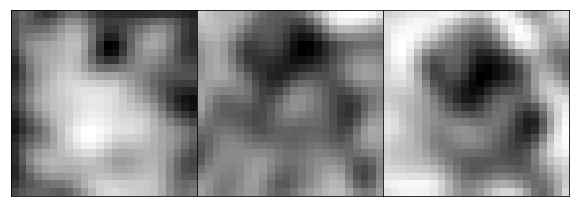

In [409]:
print(cls)
for f,strength in sorted(enumerate(p_f), key=lambda x:x[1], reverse=True):
    #if strength<0.2:
    #    break
    print("%s %.2f" % (all_features[f], log(strength+e)))

x_test_quick = x_test[img_id]#orig_data_dict[cls][0][np.where(orig_data_dict[cls][1] == indices_f[test_ix])]
hf.draw_slices(x_test_quick)

In [146]:
df = pd.read_excel(os.path.join(C.base_dir, "data", "annotated_features.xlsx"), 5)

for accnum, row in df.iterrows():
    df = df.drop(accnum)
    accnum = prv.decode(accnum[:accnum.find('_')]) + accnum[accnum.find('_'):accnum.find(' ')]
    df.loc[accnum] = row

print('\n'.join([x for x in df.index]))

E100962970_0
E103312835_1
E101083458_1
E100183257_1
E105311123_0
E104697262_0
12961059_0
12324408_0
12975280_0
12888679_2


In [193]:
Z_test_features = ['E106097391_0', 'E104978772_1', '12900535_0', 'E100150242_0', 'E105490014_0', 'E103147618_0', 'E103510187_0', 'E104657225_0', 'E100551966_0', 'E101388602_0', 'E100215900_8', 'E100215900_7', 'E104045692_0', '13104521_0', 'E100383453_0', '12943286_0', '12271995_0', 'E102315724_0', 'E104949189_0', 'E100511083_1', 'E101579471_0', '13018986_1', '13203550_8', '13112385_0', '12712463_0', '12361082_0', '13028374_0', 'E103985934_1', 'E100529980_0', '12042703_3', '12961059_0', 'E105724706_2', 'E100592424_2', 'E103104254_0', 'E104546069_0', 'E101665217_1', '12090000_0', 'E100592424_1', '12961059_1', 'E105474285_0', '12502068_1', 'E100814791_0', 'E102613189_0', 'E105427046_0', 'E102881031_1', 'E102929168_0', 'E102310482_0', 'E102095465_0', 'E101811299_0', 'E104737273_0', '12890053_0', 'E100168661_1', '12637865_0', 'E100168661_2', '12239783_0', '12707781_0', '12706568_1', '12823036_0', '12404081_0', '12365693_1']

x_test = {cls: orig_data_dict[cls][0][np.where(np.isin(orig_data_dict[cls][1], Z_test_features))] for cls in C.classes_to_include}
Z_test = {cls: orig_data_dict[cls][1][np.where(np.isin(orig_data_dict[cls][1], Z_test_features))] for cls in C.classes_to_include}

filters_test = {}
features_test = {}
for cls in C.classes_to_include:
    filters_test[cls] = model_dense_outputs.predict(x_test[cls], verbose=False)

In [ ]:
for f_ix in range(num_features):

Requirements
- feature_vectors * unit_relevance should be maximized

- np.dot(feature_vectors[i], feature_vectors[j]) should be minimized, OR
- vec_distance(feature_vectors[i], feature_vectors[j]) should be maximized for all pairs i,j

- features "turn on / off" specific units; try to minimize the number of units impacted by a given feature

- p(z|x) > .75 for all x manually annotated by z

===
- show % of evidence explained (fraction of sum of contributing units that are captured by features that turn those units on)

## Relevance calculations

In [107]:
W = model.layers[-3].get_weights()[0]
bias = model.layers[-3].get_weights()[1]

#np.dot(filter_results[0], W) * eff_mult + eff_bias

gamma, beta, mu, var = model.layers[-2].get_weights()

eff_bias = (np.zeros(6) + bias - mu) / var**.5 * gamma + beta
eff_mult = (np.ones(6) + bias - mu) / var**.5 * gamma + beta - eff_bias

W_eff = W * eff_mult# + eff_bias

#(np.dot(filter_results[0], W) + bias - mu) / var**.5 * gamma + beta

In [117]:
unit_relevance = np.empty(num_units)
discr_power = np.empty((num_units, 6))
for u_ix in range(num_units):
    unit_relevance[u_ix] = np.amax(W_eff[u_ix]) - np.amin(W_eff[u_ix])
    for c_ix in range(6):
        if W_eff[u_ix, c_ix] == np.amax(W_eff[u_ix]):
            discr_power[u_ix, c_ix] = W_eff[u_ix, c_ix] - sorted(W_eff[u_ix],reverse=True)[1]
        else:
            discr_power[u_ix, c_ix] = W_eff[u_ix, c_ix] - np.amax(W_eff[u_ix])

In [209]:
filter_results = filter_results*unit_relevance

In [217]:
avg_length = np.mean(np.apply_along_axis(get_length, 1, filter_results*unit_relevance))

In [219]:
np.sum(squash(filter_results[2] * unit_relevance * 2/avg_length)**2)

0.6239091267665856

header = ['filter_num']
for cls in C.classes_to_include:
    header += [f+"_"+cls for f in features_by_cls[cls]]

with open('E:\\feature_filters.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header)
    for f_num in range(100):
        writer.writerow([f_num] + [feature_filters[f][f_num] for cls in features for f in features_by_cls[cls]])

cls = "colorectal"
x_test_quick = orig_data_dict[cls][0][np.where(orig_data_dict[cls][1] == "E105724706_2.npy")]
x_test_quick = orig_data_dict["fnh"][0][np.where(orig_data_dict["fnh"][1] == "E104189184_0.npy")]
filters_quick = model_dense_outputs.predict(x_test_quick, verbose=False)

In [ ]:
img_num = 0
evidence = {}

for f in all_features:
    evidence[f + "/" + str(cls_features[f])] = cnna.get_evidence_strength(feature_filters[f], filters_quick[0])#filters_test[true_cls][img_num])
    #max_strength = max(max_strength, evidence[f + "/" + str(cls_features[f])])

#for f in evidence:
#    evidence[f] /= max_strength
print("Detected features:")
for f,strength in sorted(evidence.items(), key=lambda x:x[1], reverse=True)[:5]:
    #if strength > 1:
    print("- " + f, "- %d%%" % (strength*100))

hf.plot_section_auto(x_test_quick[0])#[true_cls][img_num])

In [101]:
output = {}
for cls in C.classes_to_include:
    for img_num in range(len(filters_test[cls])):
        z = Z_test[cls][img_num]
        x = np.expand_dims(x_test[cls][img_num], axis=0)
        evidence = {}
        
        output[z] = [cls]
        
        preds = model.predict(x, verbose=False)[0]
        for pred_cls, pred_conf in sorted(zip(C.classes_to_include, preds), key=lambda x:x[1], reverse=True)[:2]:
            output[z] = output[z] + [pred_cls]
        
        #for f in all_features:
        #    evidence[f + "/" + str(cls_features[f])] = get_evidence_strength(feature_filters[f], filters_test[cls][img_num])
        
        for f_ix in range(len(all_features)):
            evidence[all_features[f_ix] + "/" + str(cls_features[all_features[f_ix]])] = features_test[cls][f_ix, img_num]
        
        f1='infiltrative'
        f2='lobulated margins'
        if evidence[f1 + "/" + str(cls_features[f1])] < evidence[f2 + "/" + str(cls_features[f2])]:
            evidence.pop(f1 + "/" + str(cls_features[f1]))
        else:
            evidence.pop(f2 + "/" + str(cls_features[f2]))
        
        for f,strength in sorted(evidence.items(), key=lambda x:x[1], reverse=True):
            output[z] = output[z] + [f, strength]

In [104]:
with open('E:\\filters_pred6.csv', 'w', newline='') as csvfile:
    header = ['img_fn', 'agreement1', 'agreement2', 'true_cls', 'pred_cls1', 'pred_cls2'] + \
            [s for i in range(len(all_features)) for s in ['feature_%d' % i,'strength_%d' % i]]
    writer = csv.writer(csvfile)
    writer.writerow(header)
    for z_num in range(len(Z_test_features)):
        writer.writerow([Z_test_features[z_num]] + [output[Z_test_features[z_num]][0] in output[Z_test_features[z_num]][3], \
                        output[Z_test_features[z_num]][0] in output[Z_test_features[z_num]][5]] + output[Z_test_features[z_num]])

In [60]:
df = pd.read_excel("E:\\filters_pred3.xlsx")

In [75]:
agree = 0
for _,row in df.iterrows():
    if row["pred_cls1"] in row["feature_1"]:
        agree += 1
print(agree/60)

52
